# Animal NER Dataset Analysis

This notebook analyzes the generated animal NER dataset to understand its characteristics and distribution.

In [6]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import re

# Set plotting style
plt.style.use('ggplot')
%matplotlib inline

## 1. Load Dataset

In [7]:
with open('./models/ner/ner_data/animal_ner_dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Display dataset structure
print(f"Dataset splits: {list(dataset.keys())}")
print(f"Training examples: {len(dataset['train'])}")
print(f"Validation examples: {len(dataset['validation'])}")
print(f"Test examples: {len(dataset['test'])}")

# Show the first example
example = dataset['train'][0]
print("\nExample format:")
for key, value in example.items():
    if key == 'entities' and value:
        print(f"\n{key}:")
        for entity in value:
            entity_text = ' '.join(example['tokens'][entity['start']:entity['end']])
            print(f"  - {entity_text} ({entity['label']}): tokens {entity['start']} to {entity['end']}")
    elif key == 'tokens':
        print(f"\n{key}: {value[:10]}..." if len(value) > 10 else f"\n{key}: {value}")
    else:
        print(f"\n{key}: {value}")

Dataset splits: ['train', 'validation', 'test']
Training examples: 12000
Validation examples: 1500
Test examples: 1500

Example format:

id: example_0

tokens: ['Conservationists', 'work', 'to', 'protect', 'the', 'endangered', 'giraffes.']

entities:
  - giraffes. (ANIMAL): tokens 6 to 7

text: Conservationists work to protect the endangered giraffes.


## 2. Dataset Statistics

In [8]:
def get_dataset_stats(data):
    # Initialize statistics
    total_examples = len(data)
    examples_with_entities = 0
    total_entities = 0
    entity_lengths = []
    sentence_lengths = []
    entity_texts = []
    
    # Calculate statistics
    for example in data:
        entities = example['entities']
        tokens = example['tokens']
        sentence_lengths.append(len(tokens))
        
        if entities:
            examples_with_entities += 1
            total_entities += len(entities)
            
            for entity in entities:
                entity_length = entity['end'] - entity['start']
                entity_lengths.append(entity_length)
                entity_text = ' '.join(tokens[entity['start']:entity['end']])
                entity_texts.append(entity_text.lower())
    
    stats = {
        'total_examples': total_examples,
        'examples_with_entities': examples_with_entities,
        'examples_without_entities': total_examples - examples_with_entities,
        'entity_coverage': examples_with_entities / total_examples * 100,
        'total_entities': total_entities,
        'entities_per_example': total_entities / total_examples,
        'entities_per_positive_example': total_entities / examples_with_entities if examples_with_entities > 0 else 0,
        'avg_sentence_length': np.mean(sentence_lengths),
        'median_sentence_length': np.median(sentence_lengths),
        'max_sentence_length': np.max(sentence_lengths),
        'avg_entity_length': np.mean(entity_lengths) if entity_lengths else 0,
        'entity_texts': entity_texts
    }
    
    return stats

# Get statistics for each split
train_stats = get_dataset_stats(dataset['train'])
val_stats = get_dataset_stats(dataset['validation'])
test_stats = get_dataset_stats(dataset['test'])

# Display statistics
stats_df = pd.DataFrame({
    'Statistic': [
        'Total Examples', 
        'Examples with Entities', 
        'Examples without Entities',
        'Entity Coverage (%)',
        'Total Entities',
        'Entities per Example',
        'Entities per Positive Example',
        'Average Sentence Length (tokens)',
        'Median Sentence Length (tokens)',
        'Max Sentence Length (tokens)',
        'Average Entity Length (tokens)'
    ],
    'Train': [
        train_stats['total_examples'],
        train_stats['examples_with_entities'],
        train_stats['examples_without_entities'],
        f"{train_stats['entity_coverage']:.2f}",
        train_stats['total_entities'],
        f"{train_stats['entities_per_example']:.2f}",
        f"{train_stats['entities_per_positive_example']:.2f}",
        f"{train_stats['avg_sentence_length']:.2f}",
        f"{train_stats['median_sentence_length']:.0f}",
        f"{train_stats['max_sentence_length']:.0f}",
        f"{train_stats['avg_entity_length']:.2f}"
    ],
    'Validation': [
        val_stats['total_examples'],
        val_stats['examples_with_entities'],
        val_stats['examples_without_entities'],
        f"{val_stats['entity_coverage']:.2f}",
        val_stats['total_entities'],
        f"{val_stats['entities_per_example']:.2f}",
        f"{val_stats['entities_per_positive_example']:.2f}",
        f"{val_stats['avg_sentence_length']:.2f}",
        f"{val_stats['median_sentence_length']:.0f}",
        f"{val_stats['max_sentence_length']:.0f}",
        f"{val_stats['avg_entity_length']:.2f}"
    ],
    'Test': [
        test_stats['total_examples'],
        test_stats['examples_with_entities'],
        test_stats['examples_without_entities'],
        f"{test_stats['entity_coverage']:.2f}",
        test_stats['total_entities'],
        f"{test_stats['entities_per_example']:.2f}",
        f"{test_stats['entities_per_positive_example']:.2f}",
        f"{test_stats['avg_sentence_length']:.2f}",
        f"{test_stats['median_sentence_length']:.0f}",
        f"{test_stats['max_sentence_length']:.0f}",
        f"{test_stats['avg_entity_length']:.2f}"
    ]
})

stats_df

,Statistic,Train,Validation,Test
0,Total Examples,12000,1500,1500
1,Examples with Entities,9032,1133,1125
2,Examples without Entities,2968,367,375
3,Entity Coverage (%),75.27,75.53,75.00
4,Total Entities,14810,1821,1884
5,Entities per Example,1.23,1.21,1.26
6,Entities per Positive Example,1.64,1.61,1.67
7,Average Sentence Length (tokens),8.76,8.78,8.89
8,Median Sentence Length (tokens),9,9,9
9,Max Sentence Length (tokens),13,13,13


## 3. Entity Distribution Analysis

/tmp/ipykernel_5703/2502503783.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Animal', data=entity_df, palette='viridis')


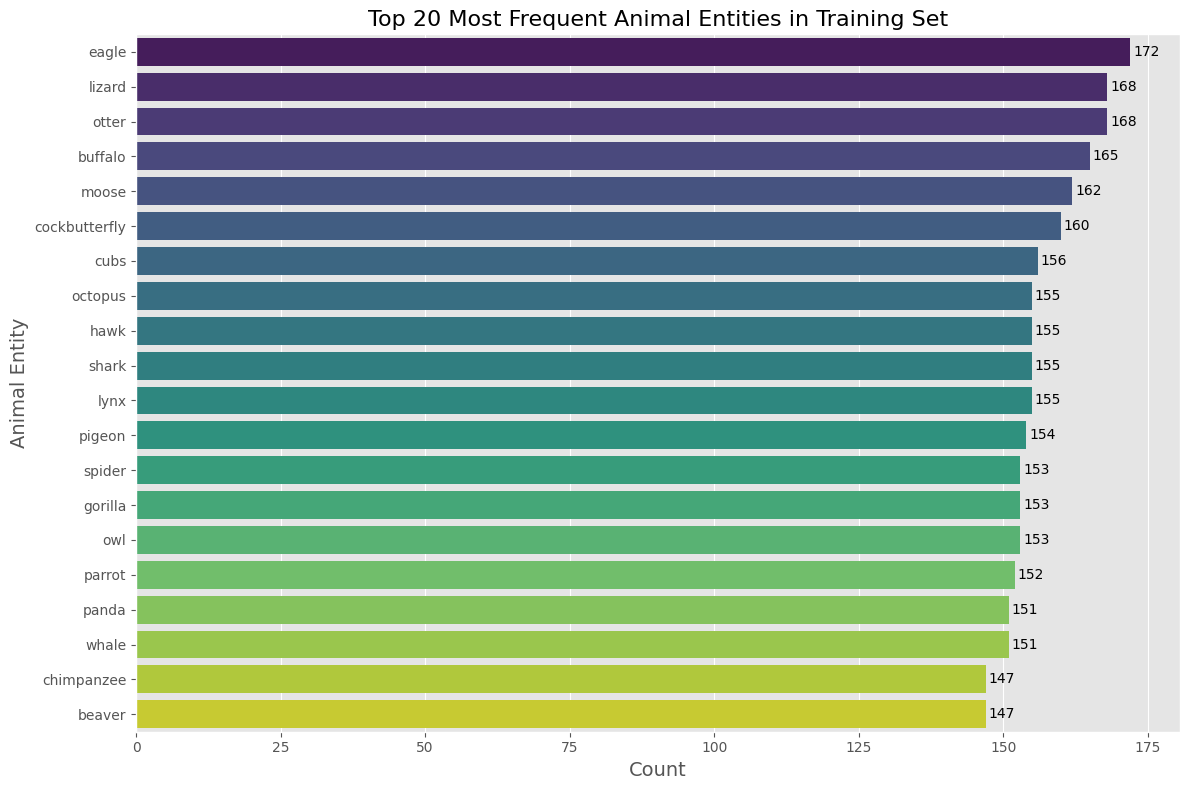

In [9]:
# Count entity occurrences
entity_counter = Counter(train_stats['entity_texts'])
top_entities = entity_counter.most_common(20)

# Create dataframe for plotting
entity_df = pd.DataFrame(top_entities, columns=['Animal', 'Count'])

# Plot top 20 entities
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Count', y='Animal', data=entity_df, palette='viridis')
plt.title('Top 20 Most Frequent Animal Entities in Training Set', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Animal Entity', fontsize=14)

# Add count labels
for i, count in enumerate(entity_df['Count']):
    ax.text(count + 0.5, i, f'{count}', va='center')

plt.tight_layout()
plt.show()

## 4. Sentence Length Distribution

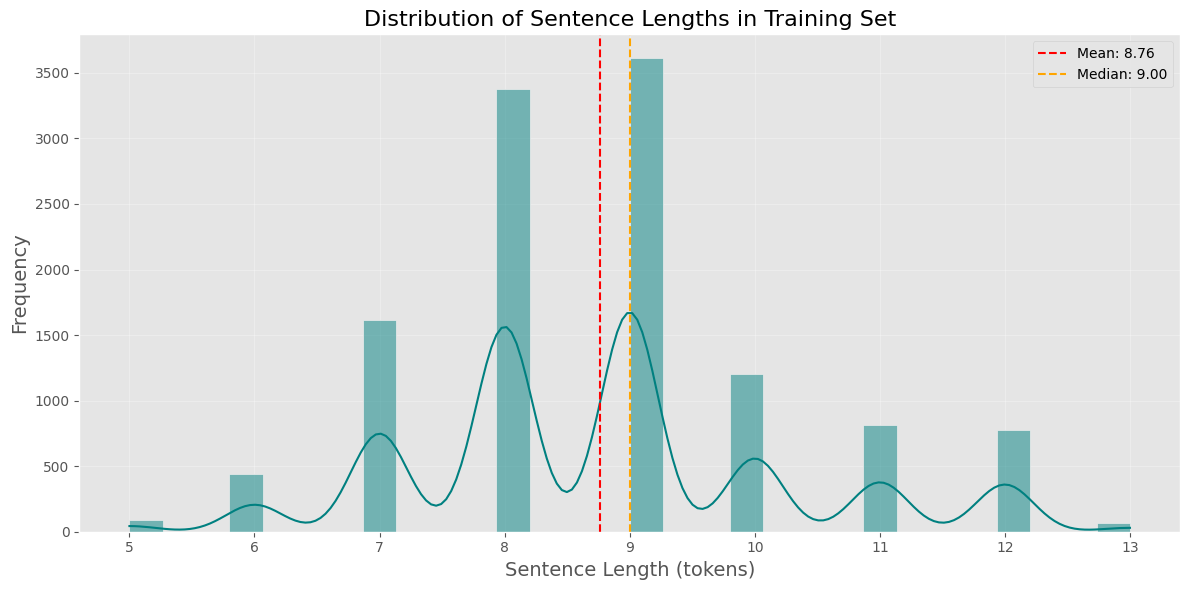

In [10]:
# Extract sentence lengths
train_sentence_lengths = [len(example['tokens']) for example in dataset['train']]

# Plot sentence length distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_sentence_lengths, bins=30, kde=True, color='teal')
plt.axvline(np.mean(train_sentence_lengths), color='red', linestyle='--', 
            label=f'Mean: {np.mean(train_sentence_lengths):.2f}')
plt.axvline(np.median(train_sentence_lengths), color='orange', linestyle='--', 
            label=f'Median: {np.median(train_sentence_lengths):.2f}')

plt.title('Distribution of Sentence Lengths in Training Set', fontsize=16)
plt.xlabel('Sentence Length (tokens)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Entity Context Analysis

In [11]:
def get_entity_context(example, entity, window=2):
    """Extract context around an entity"""
    tokens = example['tokens']
    start = max(0, entity['start'] - window)
    end = min(len(tokens), entity['end'] + window)
    
    # Mark entity in context
    context = tokens[start:entity['start']]
    entity_tokens = tokens[entity['start']:entity['end']]
    after_context = tokens[entity['end']:end]
    
    return {
        'before': ' '.join(context),
        'entity': ' '.join(entity_tokens),
        'after': ' '.join(after_context),
        'full': ' '.join(context + ['[' + ' '.join(entity_tokens) + ']'] + after_context)
    }


import random
random.seed(42)

contexts = []
for _ in range(10):
    
    while True:
        example = random.choice(dataset['train'])
        if example['entities']:
            break
    
    entity = random.choice(example['entities'])
    context = get_entity_context(example, entity, window=3)
    contexts.append(context)

context_df = pd.DataFrame(contexts)
context_df[['before', 'entity', 'after', 'full']]

,before,entity,after,full
0,I saw a,calf,in the park,I saw a [calf] in the park
1,the behavior of,beaver,in the wild.,the behavior of [beaver] in the wild.
2,The,panda,builds elaborate nests,The [panda] builds elaborate nests
3,Predators like,rabbit,hunt herbivores like,Predators like [rabbit] hunt herbivores like
4,toy is a,kits.,,toy is a [kits.]
5,painting depicts a,pony,near a waterhole.,painting depicts a [pony] near a waterhole.
6,The,rabbits,migrates thousands of,The [rabbits] migrates thousands of
7,slower than a,bison.,,slower than a [bison.]
8,exhibit was an,alligator,from Africa.,exhibit was an [alligator] from Africa.
9,sister drew a,calves,in her art,sister drew a [calves] in her art


## 6. Entity Position in Sentences

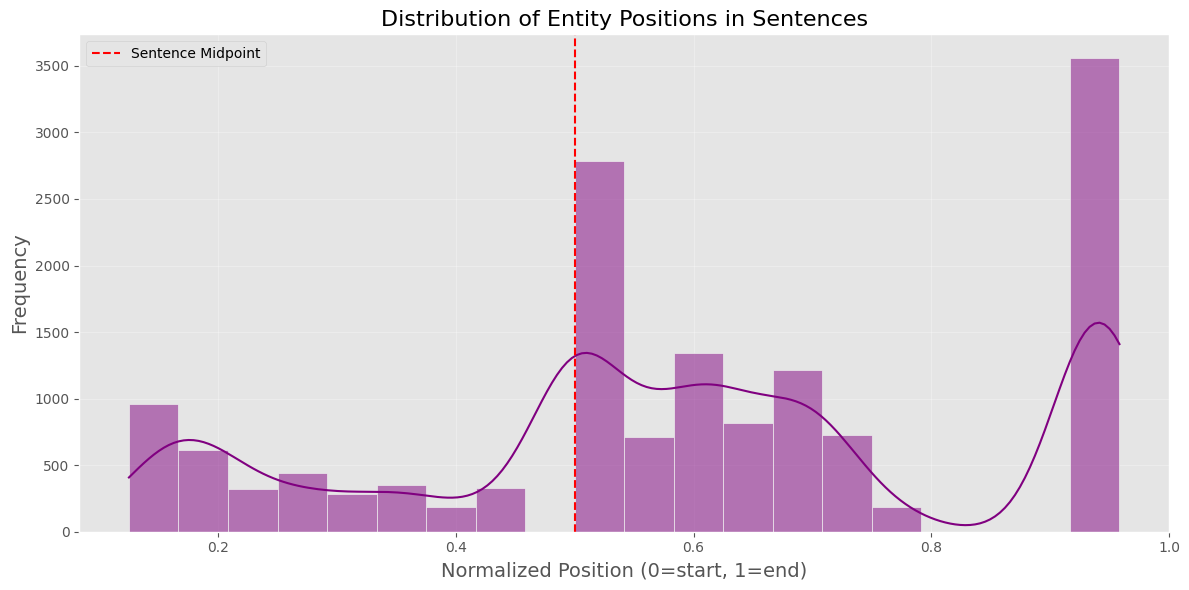

In [12]:
entity_positions = []
for example in dataset['train']:
    tokens = example['tokens']
    if len(tokens) == 0: 
        continue
        
    for entity in example['entities']:
        entity_midpoint = (entity['start'] + entity['end']) / 2
        normalized_position = entity_midpoint / len(tokens)
        entity_positions.append(normalized_position)

# Plot distribution of entity positions
plt.figure(figsize=(12, 6))
sns.histplot(entity_positions, bins=20, kde=True, color='purple')
plt.axvline(0.5, color='red', linestyle='--', label='Sentence Midpoint')

plt.title('Distribution of Entity Positions in Sentences', fontsize=16)
plt.xlabel('Normalized Position (0=start, 1=end)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Balance Check: Positive vs Negative Examples

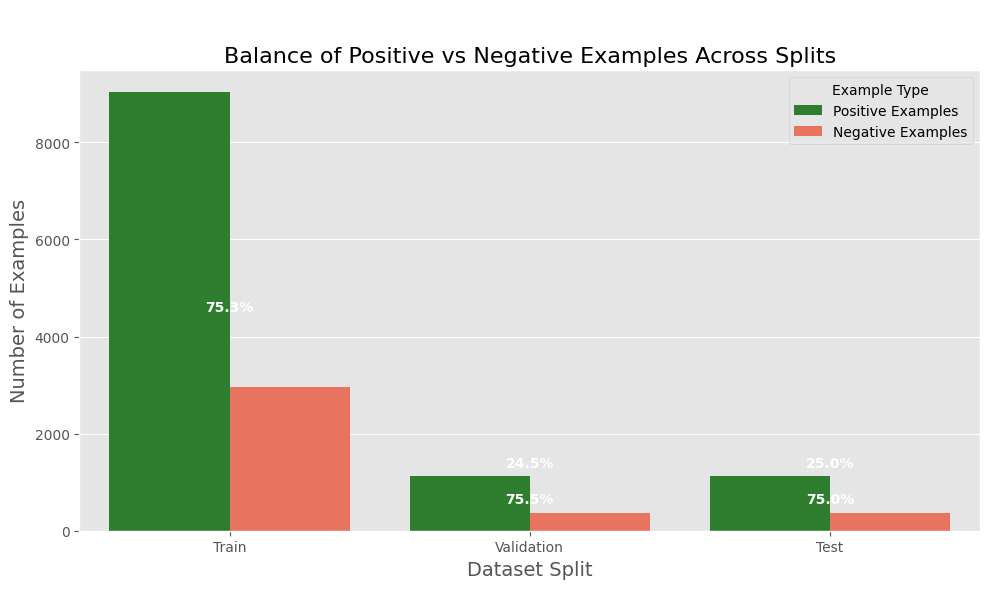

In [13]:
# Calculate statistics for various splits
def calculate_balance_stats(data):
    total = len(data)
    positive = sum(1 for ex in data if ex['entities'])
    negative = total - positive
    return {
        'total': total,
        'positive': positive,
        'negative': negative,
        'positive_pct': positive / total * 100,
        'negative_pct': negative / total * 100
    }

train_balance = calculate_balance_stats(dataset['train'])
val_balance = calculate_balance_stats(dataset['validation'])
test_balance = calculate_balance_stats(dataset['test'])

# Plot balance comparison
balance_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Positive Examples': [train_balance['positive'], val_balance['positive'], test_balance['positive']],
    'Negative Examples': [train_balance['negative'], val_balance['negative'], test_balance['negative']]
})

# Melt for stacked bar chart
balance_melt = pd.melt(balance_df, id_vars=['Split'], value_vars=['Positive Examples', 'Negative Examples'],
                        var_name='Example Type', value_name='Count')

# Create stacked bar chart
plt.figure(figsize=(10, 6))
chart = sns.barplot(x='Split', y='Count', hue='Example Type', data=balance_melt, palette=['forestgreen', 'tomato'])

# Add percentage labels
for i, split in enumerate(['Train', 'Validation', 'Test']):
    if split == 'Train':
        balance = train_balance
    elif split == 'Validation':
        balance = val_balance
    else:
        balance = test_balance
        
    total = balance['total']
    pos_height = balance['positive']
    neg_height = balance['negative']
    
    plt.text(i, pos_height/2, f"{balance['positive_pct']:.1f}%", ha='center', color='white', fontweight='bold')
    plt.text(i, pos_height + neg_height/2, f"{balance['negative_pct']:.1f}%", ha='center', color='white', fontweight='bold')

plt.title('Balance of Positive vs Negative Examples Across Splits', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Number of Examples', fontsize=14)
plt.legend(title='Example Type')
plt.tight_layout()
plt.show()

## 8. Example Review: Sample from Dataset

In [14]:
def visualize_entity(text, entities):
    """Format text with highlighted entities"""
    # Sort entities by start position (reversed to avoid index shifting)
    sorted_entities = sorted(entities, key=lambda x: x['start'], reverse=True)
    
    tokens = text.split()
    
    # Highlight entities
    for entity in sorted_entities:
        start = entity['start']
        end = entity['end']
        if start < len(tokens) and end <= len(tokens):
            # Join entity tokens and highlight
            entity_text = ' '.join(tokens[start:end])
            highlighted = f"**[{entity_text}]**"
            
            # Replace in tokens list
            tokens = tokens[:start] + [highlighted] + tokens[end:]
    
    return ' '.join(tokens)

random.seed(42)
samples = []

positive_samples = []
for _ in range(5):
    while True:
        example = random.choice(dataset['train'])
        if example['entities']:
            positive_samples.append(example)
            break

negative_samples = []
for _ in range(5):
    while True:
        example = random.choice(dataset['train'])
        if not example['entities']:
            negative_samples.append(example)
            break

# Display samples
print("\n5 EXAMPLES WITH ENTITIES:\n")
for i, example in enumerate(positive_samples, 1):
    text = ' '.join(example['tokens'])
    highlighted = visualize_entity(text, example['entities'])
    print(f"{i}. {highlighted}\n")

print("\n5 EXAMPLES WITHOUT ENTITIES:\n")
for i, example in enumerate(negative_samples, 1):
    text = ' '.join(example['tokens'])
    print(f"{i}. {text}\n")


5 EXAMPLES WITH ENTITIES:

1. I saw a **[calf]** in the park yesterday.

2. Ancient cultures worshipped both **[otter]** and **[octopus.]**

3. Scientists study the behavior of **[beaver]** in the wild.

4. Children are excited about **[shark,]** but afraid of **[sparrow.]**

5. The **[panda]** builds elaborate nests for its young.


5 EXAMPLES WITHOUT ENTITIES:

1. The museum's collection includes specimens from five continents.

2. I'm feeling like a fish out of water in my new job.

3. I ordered a fish sandwich for lunch today.

4. My daughter attends Lion Elementary School.

5. There's an elephant in the room that nobody wants to discuss.

